# Gale-Shapley (Deferred Acceptance Algorithm)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Generate Schools and Applicants Data  

In [92]:

n_a = 1000 #the number of applicants

n_s = 20 #the number of schools

n_p = 4 #the number of tiers of applicants

# generate utility randomly

a = np.zeros((n_a,n_s+1), dtype=int)


for i in range(n_a):
    a[i] = np.arange(n_s+1)
    np.random.shuffle(a[i])
    
    

#make all schools acceptable (not necesary)

a[:,n_s] = -10


# generate priority randomly    
    
b = np.zeros((n_s,n_a), dtype=int)

for i in range(n_s):
    b[i] = np.random.randint(n_p, size = n_a)
    np.random.shuffle(b[i])



applicants = pd.DataFrame(a)
applicants.index = ['a' + str(x) for x in applicants.index]
schools = pd.DataFrame(b)
schools.index = ['s' + str(x) for x in schools.index]
applicants.columns = list(schools.index) + ['self']
schools.columns = list(applicants.index)

'''
# generate school quotas randomly.
schools.insert(len(applicants.index),"quota", [np.random.randint(low=1,high=(2*len(applicants.index))//len(schools.index)) for s in schools.index])
schools_quota = {s: schools['quota'][s] for s in schools.index}
'''

# all schools have same quota.
schools_quota = {s: (len(applicants.index)//len(schools.index)-1) for s in schools.index}


# you can import or export data here

'''    
applicants.to_csv(ind)
schools.to_csv(index=False)

applicants = pd.read_csv('applicants.csv',index_col=0)
schools = pd.read_csv('schools.csv',index_col=0)

'''

# generate lotteries for single tie-breaking
lottery_s = {}

for a in applicants.index:
    lottery_s[a] = np.random.randn()
    
    
# generate lotteries for multi tie-breaking
 
lottery_m = {}

for a in applicants.index:
    lottery_m[a] = {}
    for s in schools.index:
        lottery_m[a][s] = np.random.randn()

lottery_m = pd.DataFrame(lottery_m)    


## 2. Initialize Variables

In [93]:
applicants_list_include_self = list(applicants.index) + ['self'] 
schools_list  = list(schools.index) + ['self']


schools_avail = {a: sorted(schools_list, key = lambda x: applicants.loc[a][x],reverse=True) for a in applicants.index}

applicants_avail = list(applicants.index.copy())

tentative_match = dict([key,[]] for key in schools.index)

t_match_applicants = {a: 'self' for a in list(applicants.index)}

applicants_propose = {}

school_pools = {}

accepted_applicants = []

def best_school_available(a):
    return schools_avail[a][0]

def pool_of_applicants(s):
    return [a for a in applicants_avail if s == applicants_propose[a]]

def accept_(a,s):
    tentative_match[s] = tentative_match[s] + [a] 
    
def reject_(a,s):
    if a in tentative_match[s]:
        tentative_match[s] = list(set(tentative_match[s]) - set([a])) 

count = 0

## 3. Run the DA Algorithm with Single Tie-breaking

In [94]:
while len(applicants_avail) > 0:

    for a in applicants_avail:
        applicants_propose[a] = best_school_available(a)

    # pool of applicants for each school after proposing
    for s in schools.index:
        school_pools[s] = tentative_match[s] + pool_of_applicants(s)  

    # each woman selects the best man possible save tentative matches
    for s in schools.index:
        sorted_applicants = sorted(school_pools[s], key =lambda x: (schools.loc[s][x],lottery_s[x]),reverse=True)
        if len(sorted_applicants) <= schools_quota[s]:
            tentative_match[s] = sorted_applicants
        else:
            tentative_match[s] = sorted_applicants[0:schools_quota[s]]

    
    # record accepted applicants to see who are available in the next round
    for s in schools.index:
        accepted_applicants = accepted_applicants + tentative_match[s]


    # applicants cannot reapply to the same school
    for a in applicants_avail:
        if schools_avail[a][0] != 'self':
            del schools_avail[a][0]  


    applicants_avail = [a for a in applicants.index if a not in accepted_applicants and schools_avail[a][0] != 'self']
    

    # initialize for the next loop 
    for s in schools.index:
        school_pools[s] = []

    accepted_applicants = []

    applicants_propose = {}
    
    count = count + 1

## 4. Save the Output as a DataFrame

In [95]:
for a in applicants.index:
    for s in schools.index:
        if a in tentative_match[s]:
            t_match_applicants[a] = s
            
match_schools_s = pd.DataFrame(tentative_match.values(),index = tentative_match.keys())

match_schools_s.insert(0,"empty seats",[schools_quota[s] - match_schools_s.loc[s].count()
                                      for s in match_schools_s.index])

match_applicants_s = pd.DataFrame(t_match_applicants.values(), index = t_match_applicants.keys(),columns =['match'])

match_applicants_s.insert(1,"utility",[applicants.loc[a][match_applicants_s.loc[a]['match']] 
                                      for a in match_applicants_s.index])

match_applicants_s.insert(2, 'ranking', [applicants.loc[a].rank(ascending = False).astype(int)[match_applicants_s.loc[a]['match']] 
                                         for a in match_applicants_s.index])


## 5. Initialize Variables

In [96]:
applicants_list_include_self = list(applicants.index) + ['self'] 
schools_list  = list(schools.index) + ['self']


schools_avail = {a: sorted(schools_list, key = lambda x: applicants.loc[a][x],reverse=True) for a in applicants.index}

applicants_avail = list(applicants.index.copy())

tentative_match = dict([key,[]] for key in schools.index)

t_match_applicants = {a: 'self' for a in list(applicants.index)}

applicants_propose = {}

school_pools = {}

accepted_applicants = []

def best_school_available(a):
    return schools_avail[a][0]

def pool_of_applicants(s):
    return [a for a in applicants_avail if s == applicants_propose[a]]

def accept_(a,s):
    tentative_match[s] = tentative_match[s] + [a] 
    
def reject_(a,s):
    if a in tentative_match[s]:
        tentative_match[s] = list(set(tentative_match[s]) - set([a])) 

count = 0

## 6. Run the DA Algorithm with Multie Tie-breaking

In [97]:
while len(applicants_avail) > 0:

    for a in applicants_avail:
        applicants_propose[a] = best_school_available(a)

    # pool of applicants for each school after proposing
    for s in schools.index:
        school_pools[s] = tentative_match[s] + pool_of_applicants(s)  

    # each woman selects the best man possible save tentative matches
    for s in schools.index:
        sorted_applicants = sorted(school_pools[s], key =lambda x: (schools.loc[s][x],lottery_m[x][s]),reverse=True)
        if len(sorted_applicants) <= schools_quota[s]:
            tentative_match[s] = sorted_applicants
        else:
            tentative_match[s] = sorted_applicants[0:schools_quota[s]]

    
    # record accepted applicants to see who are available in the next round
    for s in schools.index:
        accepted_applicants = accepted_applicants + tentative_match[s]


    # applicants cannot reapply to the same school
    for a in applicants_avail:
        if schools_avail[a][0] != 'self':
            del schools_avail[a][0]  


    applicants_avail = [a for a in applicants.index if a not in accepted_applicants and schools_avail[a][0] != 'self']
    

    # initialize for the next loop 
    for s in schools.index:
        school_pools[s] = []

    accepted_applicants = []

    applicants_propose = {}
    
    count = count + 1

## 7. Save the Output as a DataFrame

In [98]:
for a in applicants.index:
    for s in schools.index:
        if a in tentative_match[s]:
            t_match_applicants[a] = s
            
match_schools_m = pd.DataFrame(tentative_match.values(),index = tentative_match.keys())

match_schools_m.insert(0,"empty seats",[schools_quota[s] - match_schools_m.loc[s].count()
                                      for s in match_schools_m.index])

match_applicants_m = pd.DataFrame(t_match_applicants.values(), index = t_match_applicants.keys(),columns =['match'])

match_applicants_m.insert(1,"utility",[applicants.loc[a][match_applicants_m.loc[a]['match']] 
                                      for a in match_applicants_m.index])

match_applicants_m.insert(2, 'ranking', [applicants.loc[a].rank(ascending = False).astype(int)[match_applicants_m.loc[a]['match']] 
                                         for a in match_applicants_m.index])


## 8. Data Analysis 

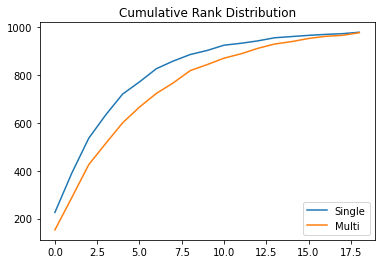

In [99]:
## rank distribution

## single tie-breaking

s_rank_dist = np.cumsum([len(match_applicants_s[match_applicants_s.ranking == i]) for i in range(1,len(schools.index))])

## multi tie-breaking
m_rank_dist = np.cumsum([len(match_applicants_m[match_applicants_m.ranking == i]) for i in range(1,len(schools.index))])



#plot
plt.title('Cumulative Rank Distribution')
plt.plot(s_rank_dist, label='Single')
plt.plot(m_rank_dist, label= 'Multi')
plt.legend(loc="lower right")
